# PM2.5 Modeling


## Executive Summary

Three different methodologies are implemented to predict the air quality (PM2.5 value) for five major Chinese cities:

* Time series PM2.5 data by itself is first modeled using ARIMA model:
The resulting ARIMA models demonstrate acceptable performance on training sets, good precision for the very first out-of-sample prediction into the future, but poor predictions for further steps into the future. This suggests that the autoaggressive and moving average patterns in the time series alone are not enough to predict multiple steps into the future.

* Various machine learn models are then constructed by incorporating available meteorological weather data in addition to the datetime features: 
Neither the simplier linear models (LinearRegression, Lasso and Ridge) nor the more advanced models (KNeighborsRegressor, RandomForestRegressor, GradientBoostingRegressor and MLPRegressor) yield satisfying performance, indicating that time-related information and weather conditions can only explain the variations in air quality (PM2.5 value) to a limited extent. The results from these machine learning models also reveal that among all meteorological parameters, wind speed (ws), temperature (temp), humidity (humi) and dew point (dewp) are the top influencers; among all datetime-related parameters, month is the most important factor, followed by hour and day.

* Additional lag feature (value from previous steps) is introduced to take into consideration its history (autoregressive nature):
The above machine learning models are updated with the new lag feature. The results reveal that, in this particular problem, it’s very useful to include the lag feature from previous steps for predicting future steps and R2 scores are boosted significantly regardless of the model used, and the best $R^2$ score achieved is 0.94. The results also suggest that among all features, the newly added lag feature accounts for about 80% of the contribution, meteological (weather) and geographic (city) features account for about 15% and the rest 5% is attributed to the datetime based features. The improved models not only forecast into the future, but also extend to predict an unseen city nicely.<br>

Both previous observed value and various weather conditions have an impact on future PM2.5 values. In the winning models, the previous observations are crucial for forecasting future steps. For practical use, additional pipeline is needed to log the forecasts, replace forecasts with new observations when available.<br>

## 1. relevant modules and the dataset

In [1]:
# import relevant module

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler #, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indic

In [2]:
# import the clean dataset
pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time']) # parse column 'date_time' as DateTime objects

# prepare features X and target variable y for machine learning models
X = pm_clean.drop(['pm_average','date_time','iws'], axis=1) 
# drop target 'pm_average', feature 'date_time' (duplicated time info), and feature 'iws' (duplicative of 'ws' and contains undesired artifacts)
X = pd.get_dummies(X, drop_first=True)  # convert categorical columns
y = pm_clean['pm_average']

In [3]:
# divide the five-city dataset into subsets by city and prepare the corresponding features and target variable by city

cities = ['beijing','chengdu','guangzhou','shanghai','shenyang']

Xs = {}  # initialize a dict to store the features by city
ys = {}  # initialize a dict to store the target variable by city

for city in cities:
    Xs[city] = pm_clean[pm_clean['city'] == city].drop(['city','pm_average','date_time'], axis=1) # extract features by city and drop irrelevant columns
    Xs[city] = pd.get_dummies(Xs[city], drop_first=True) # convert all categorical columns
    ys[city] = pm_clean[pm_clean['city'] == city]['pm_average'] # extractv target variable by city
    ys[city].name = 'pm_{}'.format(city) # update Pandas Series name accordingly

In [4]:
# prepare 'date_time' indexed time series 'pm_average' data by city for time series forecasting using ARIMA model

pms_hourly = {}  # initialize a dict to store the hourly PM2.5 time series by city
pms_daily = {}   # initialize a dcit to store the resampled daily PM2.5 time series by city

for city in cities:
    # extract hourly PM2.5 by city, set frequency as hourly and set DateTime index
    pms_hourly[city] = pm_clean[pm_clean['city'] == city].set_index('date_time')['pm_average'].resample('H').mean()
    pms_hourly[city].fillna(method='bfill',inplace=True) # backfill na if there is any missing value resulting from resampling
    pms_hourly[city].name = 'pm_hourly_{}'.format(city) # update Pandas Series name accordingly
    
    # downsampling PM2.5 by day for each city and set DateTime index
    pms_daily[city] = pm_clean[pm_clean['city'] == city].set_index('date_time')['pm_average'].resample('D').mean()
    pms_daily[city].fillna(method='bfill',inplace=True) # backfill na if there is any missing value resulting from resampling
    pms_daily[city].name = 'pm_daily_{}'.format(city) # update Pandas Series name accordingly

## 2. Modeling time series PM2.5 using ARIMA and SARIMA models
First, time series hourly and daily PM2.5 data are modeled without additional meteorological weather data using ARIMA and SARIMA models. The following procedures are followed to build the ARIMA-based models: 
1. visualize the time series
2. Dickey-Fuller stationary test, and stationarize the time series if needed
3. graph ACF and PACF plots to identify the potential parameters for building the ARIMA and SARIMA models
4. build the model using time series data of year 2010-2014
5. make predictions for year 2015 and evaluate by comparing to the actual observations

Below shows the detailed procedures and results obtained from time series pm2.5 data of city 'beijing' as an example. Similar procedures and models are also created for all other four cities, 'chengdu', 'guangzhou', 'shanghai' and 'shenyang', resulting in similar conclusions.

### 2.1 plot hourly and daily PM2.5 series to inspect the characteristics

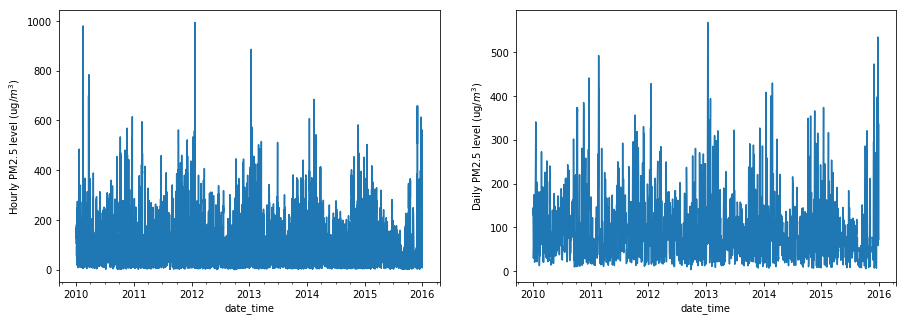

In [5]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
pms_hourly['beijing'].plot(ax=ax1); # plot hourly pm2.5 for city Beijing
ax1.set_ylabel('Hourly PM2.5 level (ug/$m^3$)');

ax2 = fig.add_subplot(122)
pms_daily['beijing'].plot(ax=ax2); # plot daily pm2.5 for city Beijing
ax2.set_ylabel('Daily PM2.5 level (ug/$m^3$)');

As shown, there is a seasonal component visible both in the hourly and in the daily time series. A stationarity test is necessary before applying the ARIMA-based models.

### 2.2 Dickey-Fuller test for stationarity
In order to use the ARIMA-based models, Dickey-Fuller Tests are conducted to determine if the hourly PM2.5 series and the daily PM2.5 series are stationary (constant mean, variance and autocorrelation across the time series dataset).
 
<li>$H_o$: Non-stationary series
<li>$H_a$: Stationary series

In [6]:
# hourly PM2.5 series

useful_values_raw = adfuller(pms_hourly['beijing'], autolag = 'AIC')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%'], 'Value':useful_values})

,Label,Value
0,Test Statistic,-22.600407
1,p-value,0.000000
2,#Lags Used,54.000000
3,Number of Observations Used,52506.000000
4,Critical value for 1%,-3.430475
5,Critical value for 5%,-2.861595
6,Critical value for 10%,-2.566799


In [7]:
# daily PM2.5 series

useful_values_raw = adfuller(pms_daily['beijing'], autolag = 'AIC')[:5]
useful_values = [v for v in useful_values_raw[:4]]
useful_values.extend([useful_values_raw[4]['1%'], useful_values_raw[4]['5%'], useful_values_raw[4]['10%']])
pd.DataFrame({'Label':['Test Statistic','p-value','#Lags Used','Number of Observations Used', 'Critical value for 1%', 'Critical value for 5%', 'Critical value for 10%'], 'Value':useful_values})

,Label,Value
0,Test Statistic,-9.998328e+00
1,p-value,1.913685e-17
2,#Lags Used,1.200000e+01
3,Number of Observations Used,2.178000e+03
4,Critical value for 1%,-3.433356e+00
5,Critical value for 5%,-2.862868e+00
6,Critical value for 10%,-2.567477e+00


As shown, the p-values are both very small (close to zero). Therefore, we can reject the null hypothesis of non-stationarity and conclude that the hourly and daily PM2.5 data are already stationary. ARIMA and SARIMA models can be used directly without any logrithmic or differencing transformations.

### 2.3 Graph ACF and PACF plots to identify the model parameters

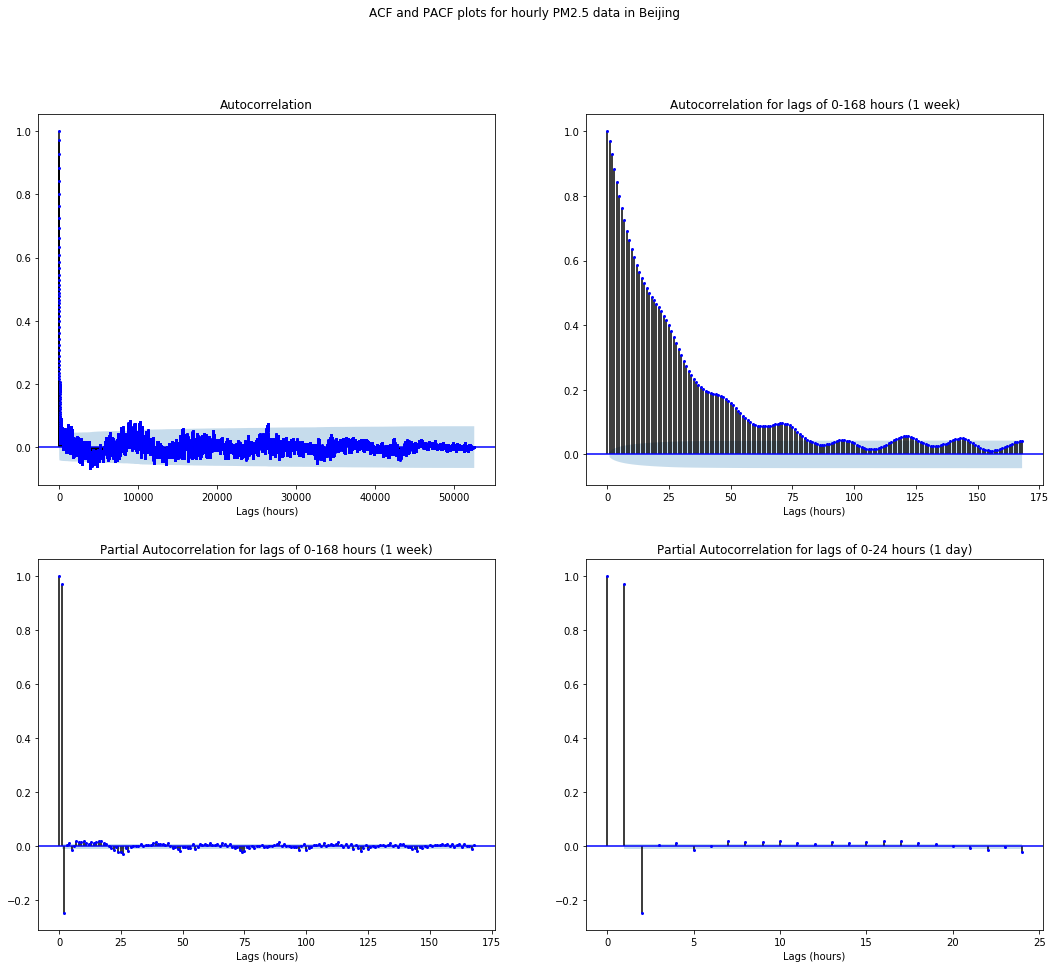

In [8]:
# hourly PM2.5 data for Beijing

fig = plt.figure(figsize=(18,15));
fig.suptitle('ACF and PACF plots for hourly PM2.5 data in Beijing');

ax1 = fig.add_subplot(221)
plot_acf(pms_hourly['beijing'], ax=ax1, color='blue',markersize=2);
ax1.set_xlabel('Lags (hours)');

ax2 = fig.add_subplot(222)
plot_acf(pms_hourly['beijing'],lags=168, ax=ax2, title='Autocorrelation for lags of 0-168 hours (1 week)', color='blue',markersize=2);
ax2.set_xlabel('Lags (hours)');

ax3 = fig.add_subplot(223)
plot_pacf(pms_hourly['beijing'], lags=168, ax=ax3, title='Partial Autocorrelation for lags of 0-168 hours (1 week)', color='blue', markersize=2);
ax3.set_xlabel('Lags (hours)');

ax4 = fig.add_subplot(224)
plot_pacf(pms_hourly['beijing'], lags=24, ax=ax4, title='Partial Autocorrelation for lags of 0-24 hours (1 day)', color='blue', markersize=2);
ax4.set_xlabel('Lags (hours)');

As the plots and data transformation reveal, the parameters for the ARIMA model should be: 
1. The number of Auto-Regressive Terms based on the pacf plot: p=1 or 2
2. The number of differences taken given that no data transformation is necessary: d=0
3. The number of Moving Average Terms based on the acf plot: q=0 or 1 or 2

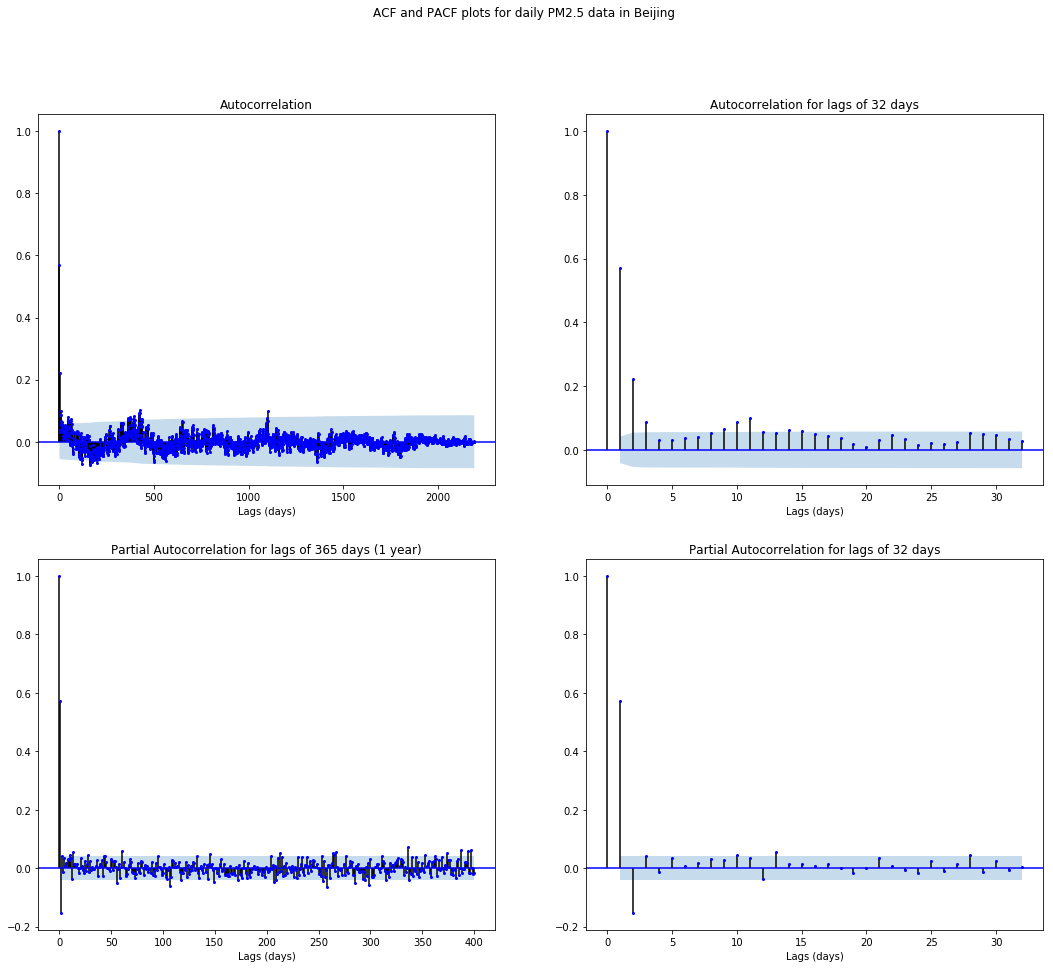

In [9]:
# daily PM2.5 data for Beijing

fig = plt.figure(figsize=(18,15));
fig.suptitle('ACF and PACF plots for daily PM2.5 data in Beijing');

ax1 = fig.add_subplot(221)
plot_acf(pms_daily['beijing'], ax=ax1, color='blue',markersize=2);
ax1.set_xlabel('Lags (days)');

ax2 = fig.add_subplot(222)
plot_acf(pms_daily['beijing'],lags=32, ax=ax2, title='Autocorrelation for lags of 32 days', color='blue',markersize=2);
ax2.set_xlabel('Lags (days)');

ax3 = fig.add_subplot(223)
plot_pacf(pms_daily['beijing'], lags=400, ax=ax3, title='Partial Autocorrelation for lags of 365 days (1 year)', color='blue', markersize=2);
ax3.set_xlabel('Lags (days)');

ax4 = fig.add_subplot(224)
plot_pacf(pms_daily['beijing'], lags=32, ax=ax4, title='Partial Autocorrelation for lags of 32 days', color='blue', markersize=2);
ax4.set_xlabel('Lags (days)');

As the plots and data transformation reveal, the parameters for the ARIMA model should be: 
1. The number of Auto-Regressive Terms based on the pacf plot: p=1 or p=2
2. The number of differences taken given that no data transformation is necessary: d=0
3. The number of Moving Average Terms based on the acf plot: q=0, 1, 2 or 3

In addiiton, as the above plots reveal, there is a somewhat significant yearly component from the ACF and PACF plots (near lags of 365 days). SARIMA model might help to better model the seasonal component in this case. 

### 2.4 build ARIMA and SARIMA models and make predictions
The hourly and daily PM2.5 data are first splitted into train and test sets by year, and ARIMA models are constructed and optimized using the parameters identified from the ACF and PACF plots. 
In addition, SARIMA model is also contructed to model the daily PM2.5 data to better address for the seasonal component observed in the time series.

In [10]:
# train test split for hourly PM2.5 data
bj_hourly_train = pms_hourly['beijing'].loc['2010':'2014']
bj_hourly_test = pms_hourly['beijing'].loc['2015']
print(len(bj_hourly_train), len(bj_hourly_test))

# train test split for daily PM2.5 data
bj_daily_train = pms_daily['beijing'].loc['2010':'2014']
bj_daily_test = pms_daily['beijing'].loc['2015']
print(len(bj_daily_train),len(bj_daily_test))

43801 8760
1826 365


#### 2.4.1 ARIMA model for hourly PM2.5 data

In [11]:
# define function for evaluating the performance of an ARIMA model with given parameters (p,d,q)
def evaluate_arima(X, p, d, q):
    """Evaluate an ARIMA model with given parameters (p,d,q) and return the mean-squared-error (MSE) performance """
    
    # divide X into training and validation datasets
    train_size = int(len(X) * 0.9)
    train, val = X[0:train_size], X[train_size:]
    
    # build the model and make predictions on the validation set
    arima = ARIMA(X[:(train_size)], order=(p,d,q))
    model_fit = arima.fit()  
    prediction = model_fit.forecast(steps=len(val))[0]
        
    # compute out of sample mean-squared-error
    mse = mean_squared_error(val, prediction) 
    return mse

# define functions for performing the grid search and identifying the optimal parameters
def grid_search_arima(X, ps, ds, qs):
    mse_best = float("inf")
    p_best, d_best, q_best = None, None, None
    for p in ps:
        for d in ds:
            for q in qs:
                try:
                    # call the evalue_arima function for model build and perform evaluation
                    mse = evaluate_arima(bj_hourly_train, p, d, q) 
                    print('ARIMA p={}, d={}, q={}, MSE={:.2f}'.format(p, d, q, mse))
                    if mse < mse_best:
                        mse_best, p_best, d_best, q_best = mse, p, d, q
                except:
                    continue
    print('Best parameters are p={}, d={}, q={}, the corresponding MSE is {:.2f}'.format(p_best, d_best, q_best, mse_best))
    return p_best, d_best, q_best

In [12]:
# grid search for optimal parameter

ps, ds, qs = [1,2], [0], [0,1,2] # use the potential q, d, q values identified from ACF and PACF Plots
p, d, q = grid_search_arima(bj_hourly_train, ps, ds, qs)

ARIMA p=1, d=0, q=0, MSE=7959.91
ARIMA p=1, d=0, q=1, MSE=7938.97
ARIMA p=1, d=0, q=2, MSE=7934.24
ARIMA p=2, d=0, q=0, MSE=7933.43
ARIMA p=2, d=0, q=1, MSE=7933.68
ARIMA p=2, d=0, q=2, MSE=7934.88
Best parameters are p=2, d=0, q=0, the corresponding MSE is 7933.43


                              ARMA Model Results                              
Dep. Variable:      pm_hourly_beijing   No. Observations:                43801
Model:                     ARMA(2, 0)   Log Likelihood             -197182.478
Method:                       css-mle   S.D. of innovations             21.820
Date:                Tue, 18 Sep 2018   AIC                         394372.956
Time:                        23:42:17   BIC                         394407.706
Sample:                    01-01-2010   HQIC                        394383.909
                         - 12-31-2014                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      97.8876      2.686     36.449      0.000      92.624     103.151
ar.L1.pm_hourly_beijing     1.1899      0.005    255.801      0.000       1.181       1.199


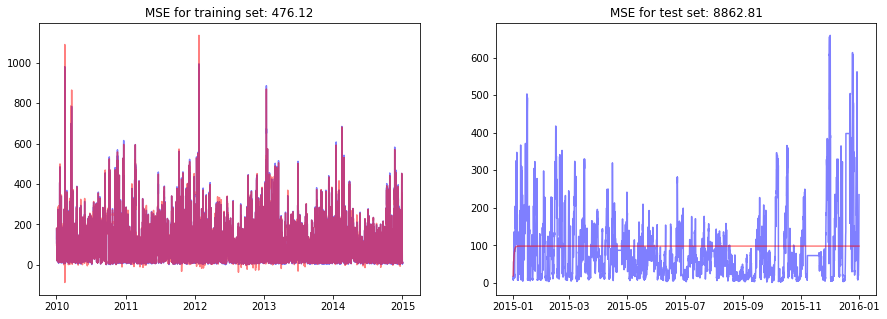

In [13]:
# construct ARIMA model using optimized parameters p, d, q
arima = ARIMA(bj_hourly_train, order=(p,d,q))
arima_fit = arima.fit()
prediction = pd.Series(arima_fit.forecast(steps=len(bj_hourly_test))[0])
prediction.index = bj_hourly_test.index
print(arima_fit.summary())

# plot the results for comparison
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121) # plot the training set
ax1.plot(bj_hourly_train, color='blue', alpha=0.5);
ax1.plot(arima_fit.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.2f}'.format(mean_squared_error(bj_hourly_train, arima_fit.fittedvalues)));
ax2 = fig.add_subplot(122) # plot the test set
ax2.plot(bj_hourly_test, color='blue',alpha=0.5);
ax2.plot(prediction, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.2f}'.format(mean_squared_error(bj_hourly_test, prediction)));

# compare the first 15 predicted values
comparison = pd.DataFrame({'actual':bj_hourly_test,'predict':prediction})
print(comparison.head(15))

#### 2.4.2 ARIMA model for daily PM2.5 data

In [14]:
# grid search for optimal parameter
ps, ds, qs = [1,2], [0], [0,1,2,3] # use the potential q, d, q values identified from ACF and PACF Plots
p, d, q = grid_search_arima(bj_daily_train, ps, ds, qs)

ARIMA p=1, d=0, q=0, MSE=7959.91
ARIMA p=1, d=0, q=1, MSE=7938.97
ARIMA p=1, d=0, q=2, MSE=7934.24
ARIMA p=1, d=0, q=3, MSE=7934.93
ARIMA p=2, d=0, q=0, MSE=7933.43
ARIMA p=2, d=0, q=1, MSE=7933.68
ARIMA p=2, d=0, q=2, MSE=7934.88
Best parameters are p=2, d=0, q=0, the corresponding MSE is 7933.43


                              ARMA Model Results                              
Dep. Variable:       pm_daily_beijing   No. Observations:                 1826
Model:                     ARMA(2, 0)   Log Likelihood              -10140.456
Method:                       css-mle   S.D. of innovations             62.447
Date:                Tue, 18 Sep 2018   AIC                          20288.913
Time:                        23:43:12   BIC                          20310.952
Sample:                    01-01-2010   HQIC                         20297.042
                         - 12-31-2014                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     98.1813      2.895     33.910      0.000      92.507     103.856
ar.L1.pm_daily_beijing     0.6543      0.023     28.323      0.000       0.609       0.700
ar.L

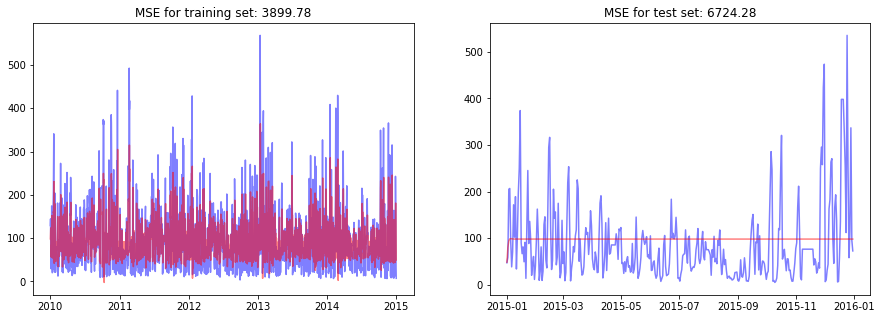

In [15]:
# construct ARIMA model using optimized parameters p, d, q
arima = ARIMA(bj_daily_train, order=(p,d,q))
arima_fit = arima.fit()
prediction = pd.Series(arima_fit.forecast(steps=len(bj_daily_test))[0])
prediction.index = bj_daily_test.index
print(arima_fit.summary())

# plot the results for comparison
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121) # plot the training set
ax1.plot(bj_daily_train, color='blue', alpha=0.5);
ax1.plot(arima_fit.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.2f}'.format(mean_squared_error(bj_daily_train, arima_fit.fittedvalues)));
ax2 = fig.add_subplot(122) # plot the test set
ax2.plot(bj_daily_test, color='blue',alpha=0.5);
ax2.plot(prediction, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.2f}'.format(mean_squared_error(bj_daily_test, prediction)));

# compare the first 15 predicted values
comparison = pd.DataFrame({'actual':bj_daily_test,'predict':prediction})
print(comparison.head(15))

In general, ARIMA models with various p,d,q combinations share very similar performances, with reasonable mean-squared-error on the training set, reasonably good prediction for the very first out-of-sample prediction into the future, but poor predictions for steps further into the future.

#### 2.4.3 SARIMA model for daily PM2.5 data

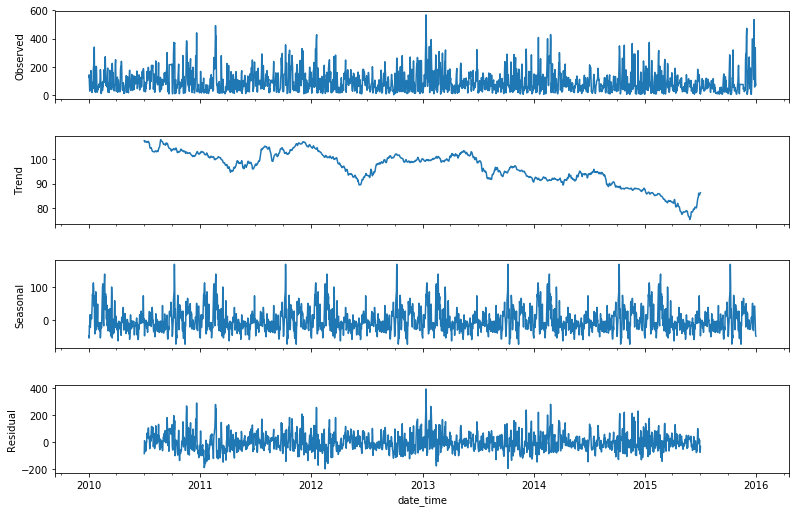

In [16]:
# decomposition
decomposition = seasonal_decompose(pms_daily['beijing'], freq=365) # freq = 1 year
fig = decomposition.plot()
fig.set_size_inches(12, 8);

As shown, decomposition with a frequency of one-year reveals a pronounced seasonality, confirming the seasonal component observed in the above ACF plot. 
In addition, there is a minor downward trend, but the Dickey-Fuller test has confirmed that the daily PM2.5 series already meets the stationary requirement, so no further tranformation is necessary. 

                                  Statespace Model Results                                 
Dep. Variable:                    pm_daily_beijing   No. Observations:                 1826
Model:             SARIMAX(1, 0, 1)x(0, 1, 0, 365)   Log Likelihood               -8632.378
Date:                             Tue, 18 Sep 2018   AIC                          17270.757
Time:                                     23:46:53   BIC                          17286.617
Sample:                                 01-01-2010   HQIC                         17276.673
                                      - 12-31-2014                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3125      0.034      9.214      0.000       0.246       0.379
ma.L1          0.3293      

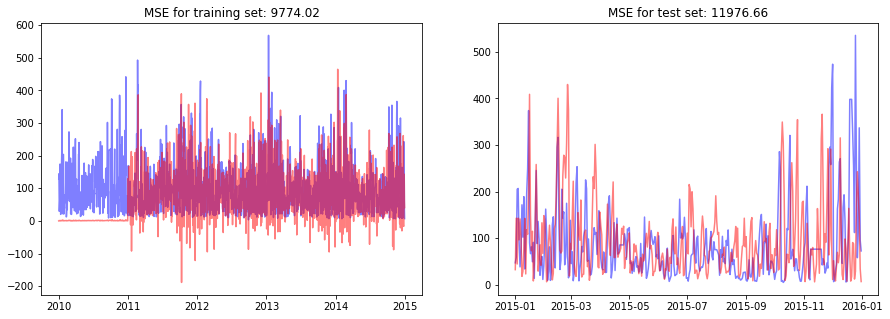

In [17]:
# use p=1, d=0, q=1 and P=0, D=1, Q=0, s=365 for constructing the Seasonal ARIMA model based on all the above analysis
sarima = SARIMAX(bj_daily_train, order=(1,0,1), seasonal_order=(0,1,0,365))
sarima_fit = sarima.fit()
print(sarima_fit.summary());
#sarima_fit.plot_diagnostics(figsize=(16,10));
prediction = pd.Series(sarima_fit.forecast(steps=len(bj_daily_test)))
prediction.index = bj_daily_test.index

# plot the results for comparison
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121) # plot the training set
ax1.plot(bj_daily_train, color='blue', alpha=0.5);
ax1.plot(sarima_fit.fittedvalues, color='red',alpha=0.5);
ax1.set_title('MSE for training set: {:.2f}'.format(mean_squared_error(bj_daily_train, sarima_fit.fittedvalues)));
ax2 = fig.add_subplot(122) # plot the test set
ax2.plot(bj_daily_test, color='blue',alpha=0.5);
ax2.plot(prediction, color='red',alpha=0.5);
ax2.set_title('MSE for test set: {:.2f}'.format(mean_squared_error(bj_daily_test, prediction)));

# compare the first 15 predicted values
comparison = pd.DataFrame({'actual':bj_daily_test,'predict':prediction})
print(comparison.head(15))

### 2.5 Section summary

Time series PM2.5 data alone is modeled using ARIMA model for each city:
* The results show that ARIMA models with various combinations of p, d, q parameters share very similar performances, with acceptable mean-squared-error on the training set, good precision for the very first out-of-sample prediction into the future, but poor predictions for further steps into the future.
* In addition, SARIMA model is also carried out for the time series PM2.5 data with a daily frequency to further account for the observed seasonal component (yearly). Again, the SARIMA model only provides a reasonable prediction for the very first data point into the future, but fails to predict further steps.
* This suggests that the autoaggressive and moving average patterns in the time series alone are not enough to predict multiple steps into the future. There are other underlying factors causing non-repetitive changes in PM2.5 values.

## 3. Machine learning models by considering meteorological weather features

### 3.1 Setup

In [18]:
# train test split by year, using data of year 2010-2014 as training set and data of year 2015 as test set

X_train = X[X['year'] != 2015]
y_train = y[X['year'] != 2015]
print(len(X_train), len(y_train))

X_test = X[X['year'] == 2015]
y_test = y[X['year'] == 2015]
print(len(X_test),len(y_test))

128309 128309
40586 40586


In [19]:
# random the index of the training set for cross validation, this is necessary because the training set is segmented by city
idx_rand = np.random.permutation(np.arange(len(X_train)))

In [20]:
# initialize a score table to log the performance of various algorithms
index = ['LinearRegression','Lasso','Ridge','RandomForestRegressor','GradientBoostingRegressor','KNeighborsRegressor','MLPRegressor']
score_table_1 = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])

In [21]:
# define function for plotting the results
def compute_plot_result(algo, pred_train, pred_test):
    """compute, log and plot the performance for both training and test sets"""
    
    # compute the performance
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    
    # log the performance
    score_table_1.loc[algo,:] = r2_train, r2_test, mse_train, mse_test
    
    # plot the predicted values vs actual for both training and test sets
    fig = plt.figure(figsize=(18,5))

    ax1 = fig.add_subplot(121) # plot training set vs prediction
    ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
    ax1.plot(X_train.index, pred_train, color='red',alpha=0.5);
    ax1.set_xlim([X_train.index[0],X_train.index[2000]]); # zoom in on the first 2000 points to compare the detailed features 
    ax1.set_xlabel('First 2000 points of the training set');
    ax1.set_ylabel('Hourly PM2.5 level (ug/$m^3$)');
    ax1.legend(['actual','predicted']);
    ax1.set_title('Training set: R2={:.2f}, MSE={:.2f}'.format(r2_train, mse_train));

    ax2 = fig.add_subplot(122) # plot test set vs prediction
    ax2.plot(X_test.index, y_test, color='blue',alpha=0.5);
    ax2.plot(X_test.index, pred_test, color='red',alpha=0.5);
    ax2.set_xlim([X_test.index[-2000],X_test.index[-1]]); # zoom in on the last 2000 points to compare the detailed features
    ax2.set_xlabel('Last 2000 points of the test set');
    ax2.set_ylabel('Hourly PM2.5 level (ug/$m^3$)');
    ax2.legend(['actual','predicted']);
    ax2.set_title('Test set: R2={:.2f}, MSE={:.2f}'.format(r2_test, mse_test));

### 3.2 Linear models

           feature  coefficient
5             dewp    12.724469
6             humi     9.097802
4           season     8.441423
3             hour     5.521620
2              day     3.533466
14         cbwd_SE     0.558647
15         cbwd_SW    -0.247224
9    precipitation    -1.337995
0             year    -2.391194
10           iprec    -4.305373
1            month    -5.351086
12         cbwd_NE    -5.437561
7             pres    -5.645293
13         cbwd_NW    -6.092561
19   city_shenyang    -8.050099
16    city_chengdu    -8.425198
11              ws   -13.350576
18   city_shanghai   -13.364758
17  city_guangzhou   -19.008694
8             temp   -25.166422


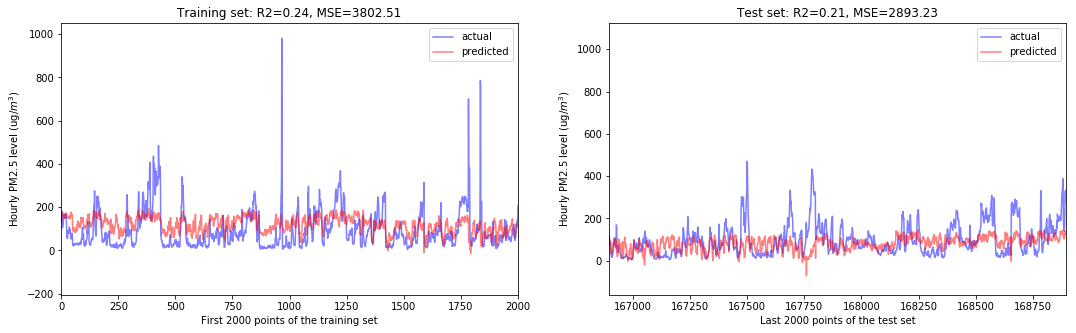

In [22]:
# simple LinearRegression model

linreg = Pipeline([('scaler', StandardScaler()),('linreg',LinearRegression())])
linreg.fit(X_train, y_train)
pred_train = linreg.predict(X_train)
pred_test = linreg.predict(X_test)
# print feature importance
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':linreg.named_steps.linreg.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

compute_plot_result('LinearRegression', pred_train, pred_test)

Best parameters: {'lasso__alpha': 0.001}
Corresponding R2 score: 0.23753142818294007
           feature  coefficient
5             dewp    12.627824
6             humi     9.142364
4           season     8.440134
3             hour     5.520374
2              day     3.532337
14         cbwd_SE     0.561717
15         cbwd_SW    -0.244699
9    precipitation    -1.337351
0             year    -2.392538
10           iprec    -4.304994
1            month    -5.349774
12         cbwd_NE    -5.434540
7             pres    -5.638338
13         cbwd_NW    -6.089734
19   city_shenyang    -8.045616
16    city_chengdu    -8.421044
11              ws   -13.352780
18   city_shanghai   -13.360327
17  city_guangzhou   -19.003466
8             temp   -25.084243


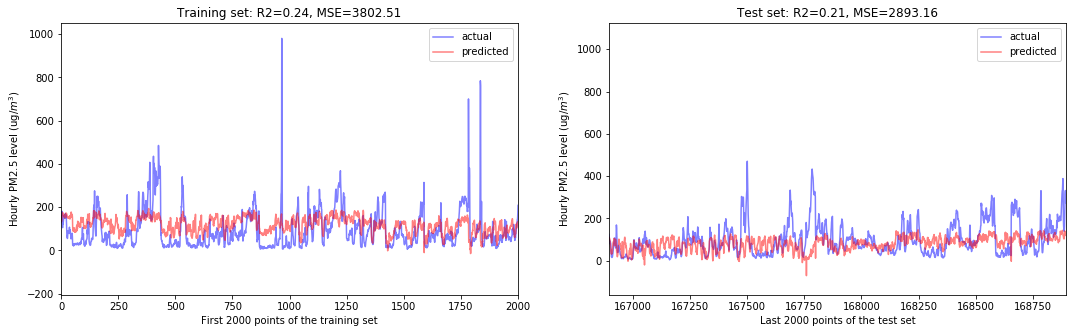

In [23]:
# LASSO model

# initialize a Lasso model with default parameters
lasso= Pipeline([('scaler', StandardScaler()),('lasso',Lasso())])

# grid search of parameter alpha to improve lasso model
parameters = {'lasso__alpha': np.arange(0.001,0.1,0.005)}
lasso_cv = GridSearchCV(lasso, parameters, scoring='r2',cv=3)
lasso_cv.fit(X_train.iloc[idx_rand], y_train.iloc[idx_rand]) # randomize the ordering of the training set
print('Best parameters:', lasso_cv.best_params_)
print('Corresponding R2 score:', lasso_cv.best_score_)

# update model with the best parameters
lasso = Pipeline([('scaler', StandardScaler()),('lasso', Lasso(alpha=0.001))])
lasso.fit(X_train, y_train)
pred_train = lasso.predict(X_train)
pred_test = lasso.predict(X_test)

# print feature ranking
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':lasso.named_steps.lasso.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

compute_plot_result('Lasso', pred_train, pred_test)

Best parameters: {'ridge__alpha': 7}
Corresponding R2 score: 0.2375313488936502
           feature  coefficient
5             dewp    12.612015
6             humi     9.151023
4           season     8.442285
3             hour     5.521288
2              day     3.533113
14         cbwd_SE     0.560549
15         cbwd_SW    -0.246610
9    precipitation    -1.338188
0             year    -2.393095
10           iprec    -4.305670
1            month    -5.351057
12         cbwd_NE    -5.436821
7             pres    -5.639944
13         cbwd_NW    -6.092227
19   city_shenyang    -8.045911
16    city_chengdu    -8.422186
11              ws   -13.352230
18   city_shanghai   -13.360625
17  city_guangzhou   -19.004164
8             temp   -25.071229


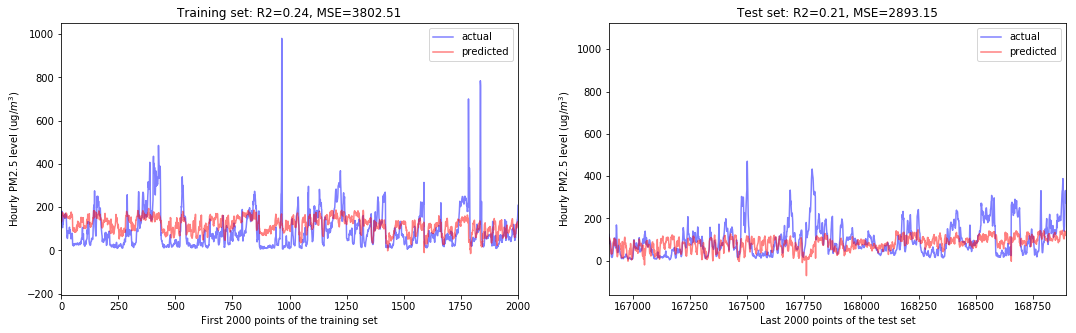

In [47]:
# Ridge model

# initialize a Ridge model with default parameters
ridge = Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])

# grid search of parameter alpha to improve lasso model
parameters = {'ridge__alpha': np.arange(1, 20, 1)}
ridge_cv = GridSearchCV(ridge, parameters, scoring='r2',cv=3)
ridge_cv.fit(X_train.iloc[idx_rand], y_train.iloc[idx_rand]) # randomize the ordering of the training set
print('Best parameters:', ridge_cv.best_params_)
print('Corresponding R2 score:', ridge_cv.best_score_)

# update model with the best parameters
ridge = Pipeline([('scaler', StandardScaler()),('ridge',Ridge(alpha=7))])
ridge.fit(X_train, y_train)
pred_train = ridge.predict(X_train)
pred_test = ridge.predict(X_test)

# print feature ranking
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':ridge.named_steps.ridge.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

compute_plot_result('Ridge', pred_train, pred_test)

### 3.3 RandomForestRegressor model

In [25]:
# initialize a RandomForestRegressor model with default parameters
rfr = Pipeline([('scaler', StandardScaler()),('rfr',RandomForestRegressor())])

# grid search of parameters n_estimators and max_features to improve RandomForestRegressor model
parameters = {'rfr__n_estimators': np.arange(50,150,10), 'rfr__max_features':['auto','sqrt','log2']}
rfr_cv = GridSearchCV(rfr, parameters, scoring='r2',cv=3)
rfr_cv.fit(X_train.iloc[idx_rand], y_train.iloc[idx_rand]) # randomize the ordering of the training set
print('Best parameters:', rfr_cv.best_params_)
print('Corresponding R2 score:', rfr_cv.best_score_)

Best parameters: {'rfr__max_features': 'auto', 'rfr__n_estimators': 130}
Corresponding R2 score: 0.779152684616797


           feature  importance
2              day    0.138232
11              ws    0.122635
8             temp    0.111608
6             humi    0.105417
7             pres    0.093661
5             dewp    0.091689
1            month    0.080276
0             year    0.068095
3             hour    0.059320
17  city_guangzhou    0.022315
4           season    0.019849
18   city_shanghai    0.019471
16    city_chengdu    0.014314
14         cbwd_SE    0.013200
19   city_shenyang    0.011254
12         cbwd_NE    0.009064
13         cbwd_NW    0.008205
10           iprec    0.004568
15         cbwd_SW    0.003964
9    precipitation    0.002862


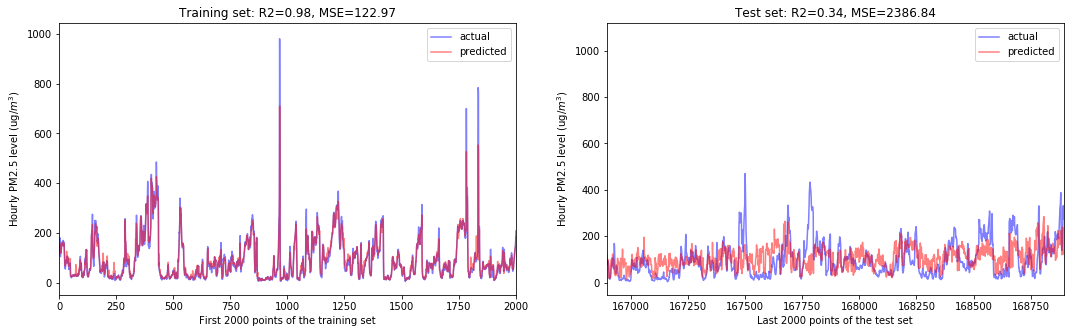

In [46]:
# update model with best parameters
rfr = Pipeline([('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=130, max_features='auto', n_jobs=2))])
rfr.fit(X_train, y_train)
pred_train = rfr.predict(X_train)
pred_test = rfr.predict(X_test)

# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfr.named_steps.rfr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

compute_plot_result("RandomForestRegressor", pred_train, pred_test)

### 3.4 GradientBoostingRegressor model

In [27]:
# initialize a GradientBoostREgressor model with default parameters
gbr = Pipeline([('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])

# grid search of parameter n_estimators, max_features, max_depth, learning_rate to improve GradientBoostingRegressor model
parameters = {'gbr__n_estimators': np.arange(50,300,50), 'gbr__learning_rate': [0.01, 0.05, 0.1, 0.15],'gbr__max_features':['auto','sqrt','log2'],'gbr__max_depth': np.arange(2,7,2)}
gbr_cv = GridSearchCV(gbr, parameters, scoring='r2',cv=3)
gbr_cv.fit(X_train.iloc[idx_rand], y_train.iloc[idx_rand]) # randomize the ordering of the training set
print('Best parameters:', gbr_cv.best_params_)
print('Corresponding R2 score:', gbr_cv.best_score_)

Best parameters: {'gbr__learning_rate': 0.15, 'gbr__max_depth': 6, 'gbr__max_features': 'auto', 'gbr__n_estimators': 250}
Corresponding R2 score: 0.696743721368328


           feature  importance
2              day    0.198480
1            month    0.122333
5             dewp    0.111779
7             pres    0.100136
0             year    0.087777
6             humi    0.080968
8             temp    0.071911
11              ws    0.051674
3             hour    0.039911
4           season    0.023255
19   city_shenyang    0.022367
18   city_shanghai    0.017999
14         cbwd_SE    0.015481
17  city_guangzhou    0.013670
16    city_chengdu    0.013061
13         cbwd_NW    0.010669
15         cbwd_SW    0.006514
10           iprec    0.005598
12         cbwd_NE    0.003905
9    precipitation    0.002512


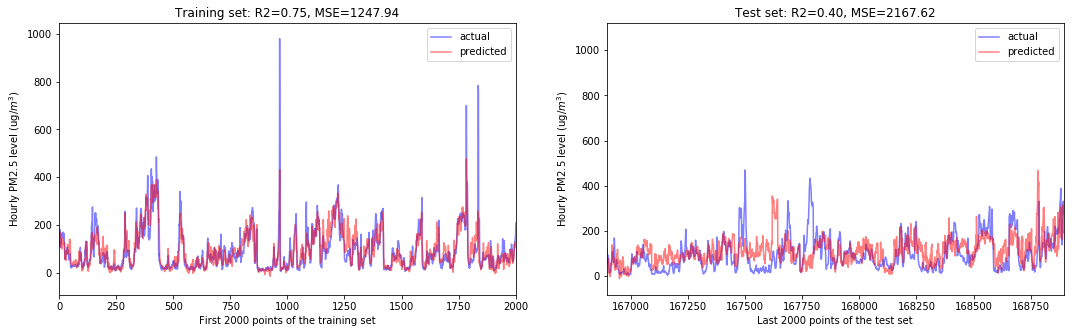

In [48]:
# update model with best parameters
gbr = Pipeline([('scaler', StandardScaler()),
                  ('gbr', GradientBoostingRegressor(n_estimators=250, learning_rate=0.15, max_features='auto', max_depth=6))])
gbr.fit(X_train, y_train)
pred_train = gbr.predict(X_train)
pred_test = gbr.predict(X_test)

# print feature importance
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

compute_plot_result("GradientBoostingRegressor", pred_train, pred_test)

### 3.5 KNeighborsRegressor model

In [45]:
# initialize a KNeightborsRegressor model using default parameters
knr = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor())])

# grid search of parameters n_neighbors, weights to improve KNeighborsRegressor model
parameters = {'knr__n_neighbors': np.arange(1,20,2),'knr__weights':['distance','uniform']}
knr_cv = GridSearchCV(knr, parameters, scoring='r2',cv=3)
knr_cv.fit(X_train.iloc[idx_rand], y_train.iloc[idx_rand]) # randomize the ordering of the training set
print('Best parameters:', knr_cv.best_params_)
print('Corresponding R2 score:', knr_cv.best_score_)

KeyboardInterrupt: 

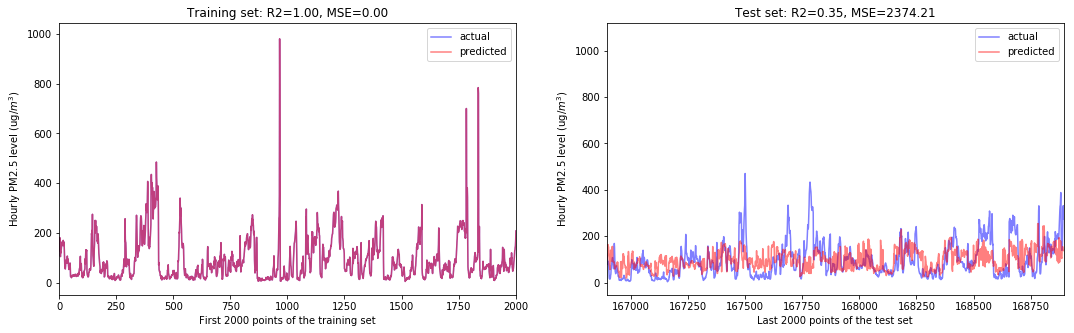

In [30]:
# update model with the best parameters
knr = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_neighbors=71, weights='distance'))])
knr.fit(X_train, y_train)
pred_train = knr.predict(X_train)
pred_test = knr.predict(X_test)

compute_plot_result("KNeighborsRegressor", pred_train, pred_test)

In [ ]:
# initialize a KNeightborsRegressor model using default parameters
knr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor())])

# grid search of parameters n_neighbors, weights to improve KNeighborsRegressor model
parameters = {'knr__n_neighbors': np.arange(1,20,2),'knr__weights':['distance','uniform']}
knr_3_cv = GridSearchCV(knr_3, parameters, scoring='r2',cv=3)
knr_3_cv.fit(X_train.iloc[idx_rand], y_train.iloc[idx_rand]) # randomize the ordering of the training set
print('Best parameters:', knr_3_cv.best_params_)
print('Corresponding R2 score:', knr_3_cv.best_score_)

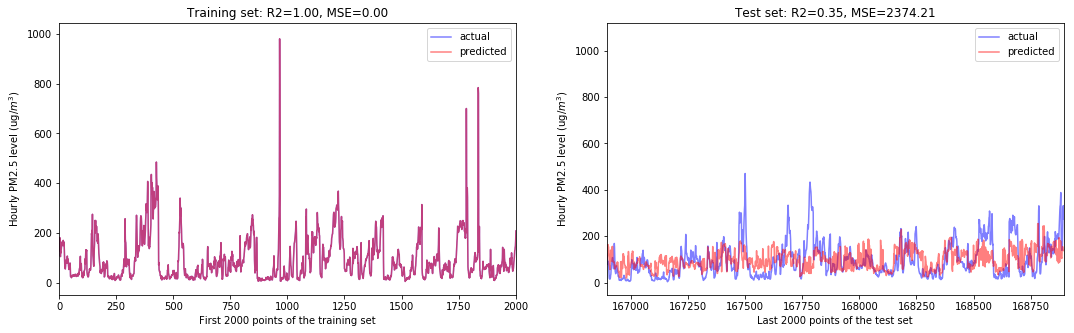

In [32]:
# update model with the best parameters
knr_3 = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_neighbors=71, weights='distance'))])
knr_3.fit(X_train, y_train)
pred_train = knr_3.predict(X_train)
pred_test = knr_3.predict(X_test)

compute_plot_result("KNeighborsRegressor", pred_train, pred_test)

### 3.6 MLPRegressor model

In [33]:
# initialize a MLPRegressor model using default parameters
mlpr = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor())])

# grid search of parameters hidden_layer_sizes, activation to improve MLPRegressor model
parameters = {'mlpr__activation': ['identity','logistic','tanh','relu'],'mlpr__hidden_layer_sizes':[(100,),(100,20),(50,100),(50,100,20)]}
mlpr_cv = GridSearchCV(mlpr, parameters, scoring='r2',cv=3)
mlpr_cv.fit(X_train.iloc[idx_rand], y_train.iloc[idx_rand]) # randomize the ordering of the training set
print('Best parameters:', mlpr_cv.best_params_)
print('Corresponding R2 score:', mlpr_cv.best_score_)

Best parameters: {'mlpr__activation': 'tanh', 'mlpr__hidden_layer_sizes': (50, 100, 20)}
Corresponding R2 score: 0.7441747365616368


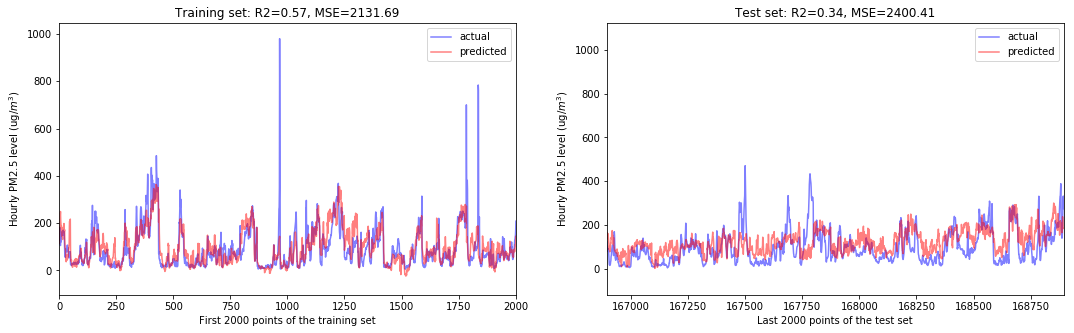

In [51]:
# update model with the best parameters
mlpr = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))])
mlpr.fit(X_train, y_train)
pred_train = mlpr.predict(X_train)
pred_test = mlpr.predict(X_test)

compute_plot_result("MLPRegressor", pred_train, pred_test)

### 3.7 Model comparison

In [52]:
print(score_table_1)

                           r2_train   r2_test mse_train mse_test
LinearRegression           0.237894  0.205384   3802.51  2893.23
Lasso                      0.237894  0.205403   3802.51  2893.16
Ridge                      0.237894  0.205405   3802.51  2893.15
RandomForestRegressor      0.975354  0.344462   122.972  2386.84
GradientBoostingRegressor  0.749886   0.40467   1247.94  2167.62
KNeighborsRegressor               1  0.347931         0  2374.21
MLPRegressor               0.572762  0.340735   2131.69  2400.41


In addition, separate machine learning models are built for individual cities. Below shows the results of models developed for city Beijing. As shown, by separating out the 'city' feature into individual models, R2 is improved to some extent. (The increase in mean-squared-error is due to the large PM2.5 variation in the subset of Beijing) 

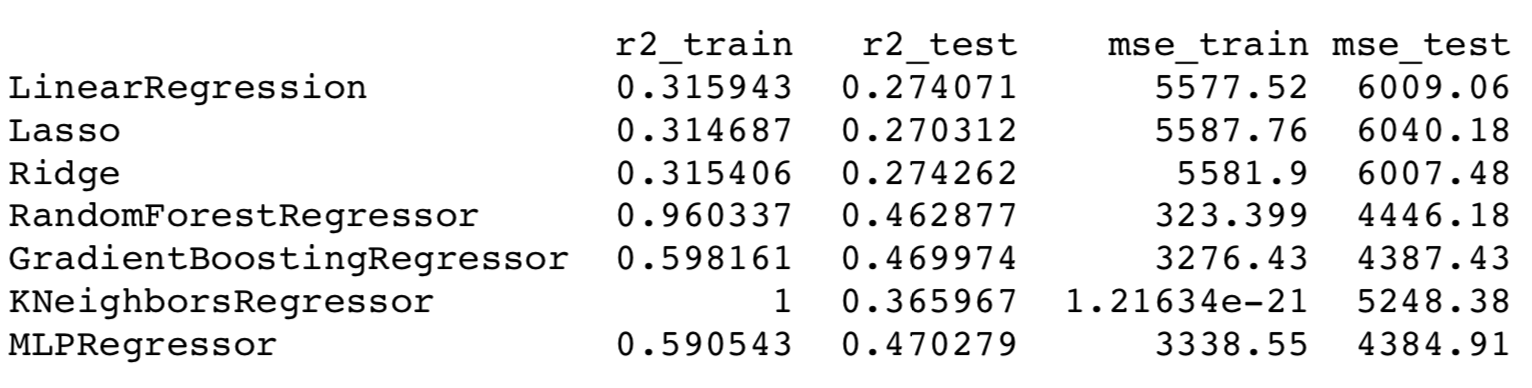

### 3.8 Section summary

Machine learn models are constructed by incorporating available meteorological weather data (temperature, pressure, dew point, wind direction, wind speed, precipitation): <br>
* Here, the datetime information is represented as year, month, day, hour and season, and used as features along with the meteorological data. Data of all five cities in year 2010-2014 are used as training set, and data of five cities in year 2015 is used as the holdout test set.<br>
* Various machine learning models are constructed following this methodology. Simplier linear models (LinearRegression, Lasso and Ridge) only achieves R2=0.21 on the test set. Among more advanced models, KNeighborsRegressor gives R2 of 0.35; ensemble methods, like RandomForestRegressor and GradientBoostingRegressor, achieve R2 of 0.35-0.4; In addition, nueral-net based MLPRegressor is also tried out with a reported R2 of 0.35. <br>
* The results from these machine learning models reveal that among all meteorological parameters, wind speed (ws), temperature (temp), humidity (humi) and dew point (dewp) are the top influencers; among all datetime-related parameters, month is the most important factor, followed by hour and day. <br>
* In addition, separate machine learning models are built for individual cities. By separating out the 'city' feature into individual models, R2 is improved from 0.35-0.4 to 0.45-0.5. But, further improvements are hard without additional feature engineering. <br> 
* These suggest that although time-related information and weather conditions can only explain the variations in air quality (PM2.5 value) to a limited extent. There are other underlying reasons causing the PM2.5 trends and variations. <br>

## 4. Machine learning models with additonal feature engineering for time series
Here, an additional lag feature of 1 hour (value from the previous one step) is introduced. Given that the PM2.5 values is a hourly time series and entries from previous steps will impact later entries to some extent, the introduce of new lag feature will enable this autoregressive impact. 

As shown below, in this particular problem, it’s very useful to include the lag features from previous step for predicting the value for the next step, the R2 scores after adding lag features are boosted significantly.

### 4.1 Set up

In [36]:
# add lag features by adding the PM2.5 value from the previous step (previous hour)
pm_clean['pm_1hr'] = pm_clean['pm_average'].shift(1)
pm_clean.dropna(inplace=True)

X_2 = pm_clean.drop(['pm_average','date_time','iws'], axis=1) 
# drop target 'pm_average', feature 'date_time' (duplicated time info), and feature 'iws' (duplicative of 'ws' and contains undesired artifacts)
X_2 = pd.get_dummies(X_2, drop_first=True)  # convert categorical columns
y_2 = pm_clean['pm_average']

In [37]:
# train test split by year and city
# set aside data of year 2015 and data of city 'shenyang' as the test set (holdout set), use data of year 2010-2014 for the other four cities as the training set
X_2_train = X_2[(X_2['year'] != 2015) & (X_2['city_shenyang'] != 1)]
y_2_train = y_2[(X_2['year'] != 2015) & (X_2['city_shenyang'] != 1)]
X_2_test = X_2[(X_2['year'] == 2015 )|(X_2['city_shenyang'] == 1)]
y_2_test = y_2[(X_2['year'] == 2015 )|(X_2['city_shenyang'] == 1)]
print(len(X_2_train), len(y_2_train))
print(len(X_2_test),len(y_2_test))

112014 112014
56880 56880


In [38]:
# random the index of the training set for cross validation, this is necessary because the training set is ordered by city then by time
idx_rand_2 = np.random.permutation(np.arange(len(X_2_train)))

In [39]:
# initialize a score table to log the performance of various algorithms
index = ['LinearRegression','Lasso','Ridge','RandomForestRegressor','GradientBoostingRegressor','KNeighborsRegressor','MLPRegressor']
score_table_2 = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])

In [40]:
# define function for plotting the results of algorithms with additional lag feature
def compute_plot_result_2(algo, pred_train, pred_test):
    """compute, log and plot the performance for both training and test sets"""
    
    # compute the performance
    r2_train = r2_score(y_2_train, pred_train)
    r2_test = r2_score(y_2_test, pred_test)
    mse_train = mean_squared_error(y_2_train, pred_train)
    mse_test = mean_squared_error(y_2_test, pred_test)
    
    # log the performance
    score_table_2.loc[algo,:] = r2_train, r2_test, mse_train, mse_test
    
    # plot the predicted values vs actual for both training and test sets
    fig = plt.figure(figsize=(18,5))

    ax1 = fig.add_subplot(121) # plot training set vs prediction
    ax1.plot(X_2_train.index, y_2_train, color='blue',alpha=0.5);
    ax1.plot(X_2_train.index, pred_train, color='red',alpha=0.5);
    ax1.set_xlim([X_2_train.index[0],X_2_train.index[2000]]); # zoom in on the first 2000 points to compare the detailed features 
    ax1.set_xlabel('First 2000 points of the training set');
    ax1.set_ylabel('Hourly PM2.5 level (ug/$m^3$)');
    ax1.legend(['actual','predicted']);
    ax1.set_title('Training set: R2={:.2f}, MSE={:.2f}'.format(r2_train, mse_train));

    ax2 = fig.add_subplot(122) # plot test set vs prediction
    ax2.plot(X_2_test.index, y_2_test, color='blue',alpha=0.5);
    ax2.plot(X_2_test.index, pred_test, color='red',alpha=0.5);
    ax2.set_xlim([X_2_test.index[-2000],X_2_test.index[-1]]); # zoom in on the last 2000 points to compare the detailed features
    ax2.set_xlabel('Last 2000 points of the test set');
    ax2.set_ylabel('Hourly PM2.5 level (ug/$m^3$)');
    ax2.legend(['actual','predicted']);
    ax2.set_title('Test set: R2={:.2f}, MSE={:.2f}'.format(r2_test, mse_test));

### 4.2 Linear models with the new lag feature

           feature  coefficient
12          pm_1hr    66.390046
3             hour     1.273655
6             humi     1.090784
4           season     0.265678
2              day     0.144904
15         cbwd_SE     0.128524
19   city_shanghai     0.124543
20   city_shenyang     0.000000
1            month    -0.009602
10           iprec    -0.025752
16         cbwd_SW    -0.068952
0             year    -0.231017
17    city_chengdu    -0.566138
18  city_guangzhou    -0.691354
8             temp    -0.726316
9    precipitation    -0.841589
13         cbwd_NE    -0.857734
7             pres    -1.046237
14         cbwd_NW    -1.160756
5             dewp    -1.449364
11              ws    -2.346404


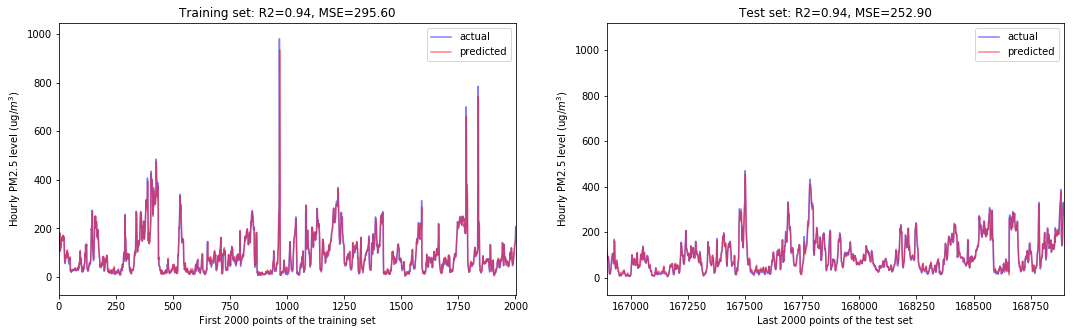

In [41]:
# simple LinearRegression model with the new lag feature

linreg_2 = Pipeline([('scaler', StandardScaler()),('linreg',LinearRegression())])
linreg_2.fit(X_2_train, y_2_train)
pred_train = linreg_2.predict(X_2_train)
pred_test = linreg_2.predict(X_2_test)

feature_rank = pd.DataFrame({'feature':X_2_train.columns, 'coefficient':linreg_2.named_steps.linreg.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

compute_plot_result_2('LinearRegression', pred_train, pred_test)

Best parameters: {'lasso__alpha': 0.001}
Corresponding R2 score: 0.9395234353491049
           feature  coefficient
12          pm_1hr    66.392688
3             hour     1.261251
6             humi     0.920419
4           season     0.245745
2              day     0.137998
15         cbwd_SE     0.132962
19   city_shanghai     0.102384
20   city_shenyang     0.000000
1            month    -0.006812
10           iprec    -0.017049
16         cbwd_SW    -0.060428
0             year    -0.225424
17    city_chengdu    -0.564225
18  city_guangzhou    -0.679967
9    precipitation    -0.836074
13         cbwd_NE    -0.842571
8             temp    -0.945471
7             pres    -0.990245
5             dewp    -1.113117
14         cbwd_NW    -1.141258
11              ws    -2.335357


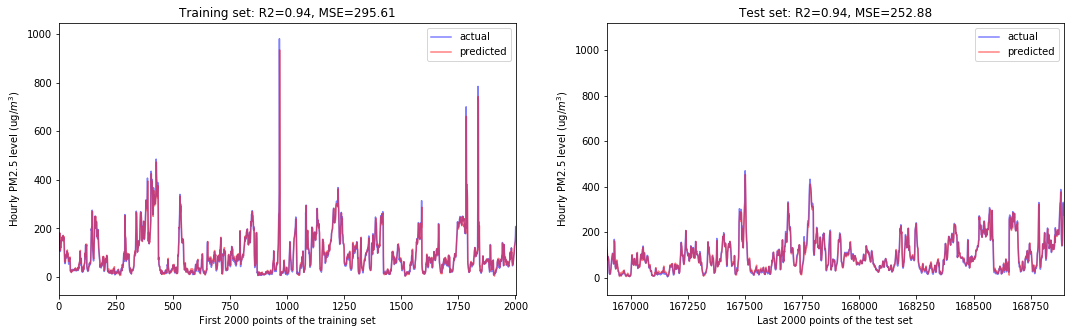

In [42]:
# LASSO model with the new lag feature

# initialize a Lasso model with default parameters
lasso_2= Pipeline([('scaler', StandardScaler()),('lasso',Lasso())])

# grid search of parameter alpha to improve lasso model
parameters = {'lasso__alpha': np.arange(0.001,0.1,0.005)}
lasso_2_cv = GridSearchCV(lasso_2, parameters, scoring='r2',cv=3)
lasso_2_cv.fit(X_2_train.iloc[idx_rand_2], y_2_train.iloc[idx_rand_2]) # randomize the ordering of the training set
print('Best parameters:', lasso_2_cv.best_params_)
print('Corresponding R2 score:', lasso_2_cv.best_score_)

# update model with the best parameters
lasso_2 = Pipeline([('scaler', StandardScaler()),('lasso', Lasso(alpha=0.001))])
lasso_2.fit(X_2_train, y_2_train)
pred_train = lasso_2.predict(X_2_train)
pred_test = lasso_2.predict(X_2_test)

# print feature ranking
feature_rank = pd.DataFrame({'feature':X_2_train.columns, 'coefficient':lasso_2.named_steps.lasso.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

compute_plot_result_2('Lasso', pred_train, pred_test)

Best parameters: {'ridge__alpha': 7}
Corresponding R2 score: 0.9395233765038328
           feature  coefficient
12          pm_1hr    66.387754
3             hour     1.273753
6             humi     1.089667
4           season     0.265921
2              day     0.144997
15         cbwd_SE     0.128553
19   city_shanghai     0.123981
20   city_shenyang     0.000000
1            month    -0.009804
10           iprec    -0.025892
16         cbwd_SW    -0.068955
0             year    -0.231094
17    city_chengdu    -0.566416
18  city_guangzhou    -0.692017
8             temp    -0.729093
9    precipitation    -0.841574
13         cbwd_NE    -0.857878
7             pres    -1.046304
14         cbwd_NW    -1.160816
5             dewp    -1.446129
11              ws    -2.346720


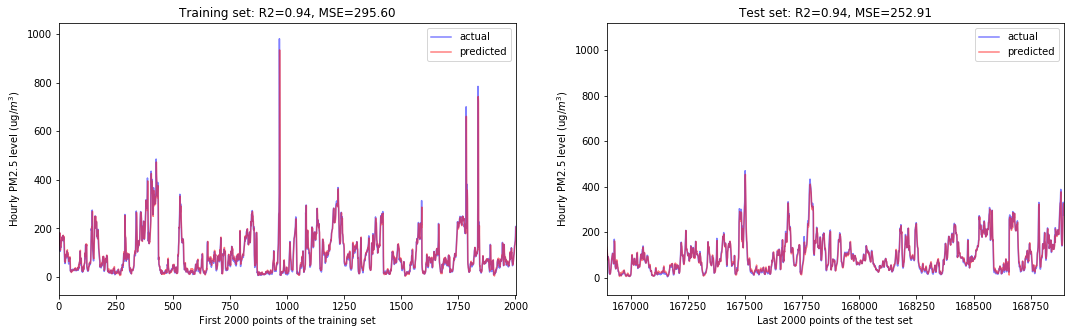

In [43]:
# Ridge model with the new lag feature

# initialize a Ridge model with default parameters
ridge_2 = Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])

# grid search of parameter alpha to improve lasso model
parameters = {'ridge__alpha': np.arange(1, 20, 1)}
ridge_2_cv = GridSearchCV(ridge_2, parameters, scoring='r2',cv=3)
ridge_2_cv.fit(X_2_train.iloc[idx_rand_2], y_2_train.iloc[idx_rand_2]) # randomize the ordering of the training set
print('Best parameters:', ridge_2_cv.best_params_)
print('Corresponding R2 score:', ridge_2_cv.best_score_)

# update model with the best parameters
ridge_2 = Pipeline([('scaler', StandardScaler()),('ridge', Ridge(alpha=7))])
ridge_2.fit(X_2_train, y_2_train)
pred_train = ridge_2.predict(X_2_train)
pred_test = ridge_2.predict(X_2_test)

# print feature ranking
feature_rank = pd.DataFrame({'feature':X_2_train.columns, 'coefficient':ridge_2.named_steps.ridge.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

compute_plot_result_2('Ridge', pred_train, pred_test)

### 4.3 RandomForestRegressor model with the new lag feature

In [44]:
# initialize a RandomForestRegressor model with default parameters
rfr_2 = Pipeline([('scaler', StandardScaler()),('rfr',RandomForestRegressor())])

# grid search of parameters n_estimators and max_features to improve RandomForestRegressor model
parameters = {'rfr__n_estimators': np.arange(50,150,10), 'rfr__max_features':['auto','sqrt','log2']}
rfr_2_cv = GridSearchCV(rfr_2, parameters, scoring='r2',cv=3)
rfr_2_cv.fit(X_2_train.iloc[idx_rand_2], y_2_train.iloc[idx_rand_2]) # randomize the ordering of the training set
print('Best parameters:', rfr_2_cv.best_params_)
print('Corresponding R2 score:', rfr_2_cv.best_score_)

KeyboardInterrupt: 

           feature  importance
12          pm_1hr    0.692010
11              ws    0.057585
5             dewp    0.034592
8             temp    0.032684
6             humi    0.032414
7             pres    0.023254
2              day    0.019657
1            month    0.017558
0             year    0.016264
3             hour    0.014316
4           season    0.012089
18  city_guangzhou    0.011495
19   city_shanghai    0.010122
13         cbwd_NE    0.006353
17    city_chengdu    0.005086
14         cbwd_NW    0.004748
15         cbwd_SE    0.004198
10           iprec    0.002779
9    precipitation    0.001951
16         cbwd_SW    0.000844
20   city_shenyang    0.000000


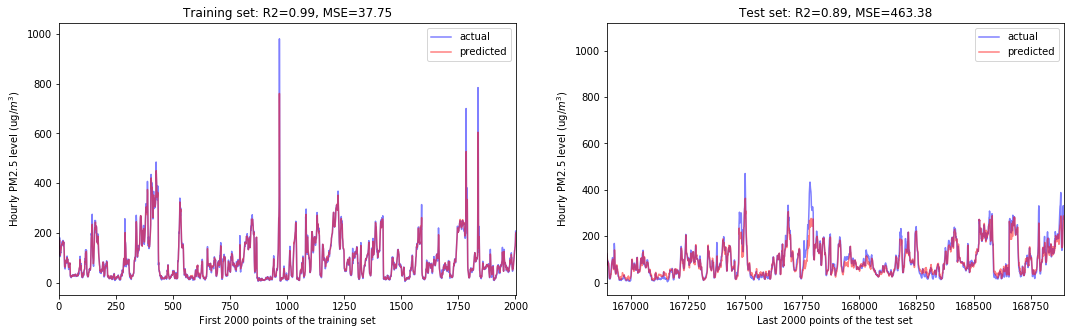

In [53]:
# update model with best parameters
rfr_2 = Pipeline([('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=140, max_features='log2', n_jobs=2))])
rfr_2.fit(X_2_train, y_2_train)
pred_train = rfr_2.predict(X_2_train)
pred_test = rfr_2.predict(X_2_test)

# print feature importance
feature_rank = pd.DataFrame({'feature': X_2_train.columns, 'importance': rfr_2.named_steps.rfr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

compute_plot_result_2("RandomForestRegressor", pred_train, pred_test)

### 4.4 GradientBoostingRegressor model with the new lag feature

In [ ]:
# initialize a GradientBoostREgressor model with default parameters
gbr_2 = Pipeline([('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])

# grid search of parameter n_estimators, max_features, max_depth, learning_rate to improve GradientBoostingRegressor model
parameters = {'gbr__n_estimators': np.arange(50,300,50), 'gbr__learning_rate': [0.01, 0.05, 0.1, 0.15],'gbr__max_features':['auto','sqrt','log2'],'gbr__max_depth': np.arange(2,7,2)}
gbr_2_cv = GridSearchCV(gbr_2, parameters, scoring='r2',cv=3)
gbr_2_cv.fit(X_2_train.iloc[idx_rand_2], y_2_train.iloc[idx_rand_2]) # randomize the ordering of the training set
print('Best parameters:', gbr_2_cv.best_params_)
print('Corresponding R2 score:', gbr_2_cv.best_score_)

           feature  importance
12          pm_1hr    0.786940
11              ws    0.046338
6             humi    0.022633
5             dewp    0.020268
8             temp    0.017903
7             pres    0.014352
1            month    0.013910
3             hour    0.013370
0             year    0.011867
4           season    0.011271
18  city_guangzhou    0.008124
19   city_shanghai    0.007505
2              day    0.005681
17    city_chengdu    0.004208
15         cbwd_SE    0.003298
14         cbwd_NW    0.003245
10           iprec    0.002894
9    precipitation    0.002775
13         cbwd_NE    0.002353
16         cbwd_SW    0.001065
20   city_shenyang    0.000000


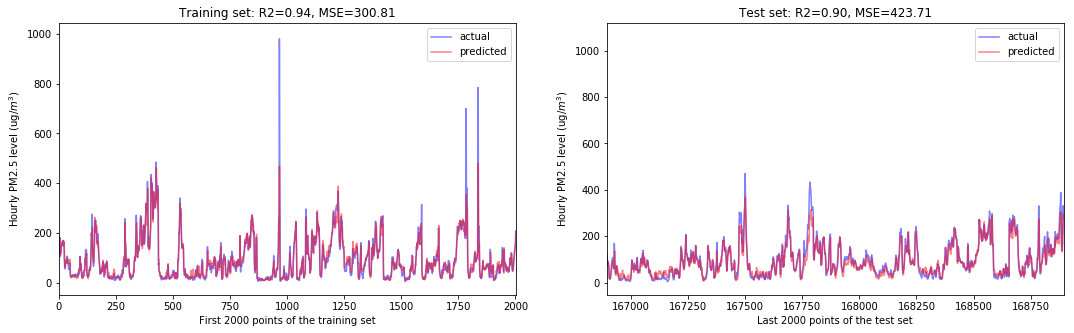

In [54]:
# update model with best parameters
gbr_2 = Pipeline([('scaler', StandardScaler()),
                  ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_features='log2', max_depth=6))])
gbr_2.fit(X_2_train, y_2_train)
pred_train = gbr_2.predict(X_2_train)
pred_test = gbr_2.predict(X_2_test)

# print feature importance
feature_rank = pd.DataFrame({'feature': X_2_train.columns, 'importance': gbr_2.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

compute_plot_result_2("GradientBoostingRegressor", pred_train, pred_test)

### 4.5 KNeighborsRegressor model with the new lag feature

In [ ]:
# initialize a KNeightborsRegressor model using default parameters
knr_2 = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor())])

# grid search of parameters n_neighbors, weights to improve KNeighborsRegressor model
parameters = {'knr__n_neighbors': np.arange(1,100,10),'knr__weights':['distance','uniform']}
knr_2_cv = GridSearchCV(knr_2, parameters, scoring='r2',cv=3)
knr_2_cv.fit(X_2_train.iloc[idx_rand_2], y_2_train.iloc[idx_rand_2]) # randomize the ordering of the training set
print('Best parameters:', knr_2_cv.best_params_)
print('Corresponding R2 score:', knr_2_cv.best_score_)

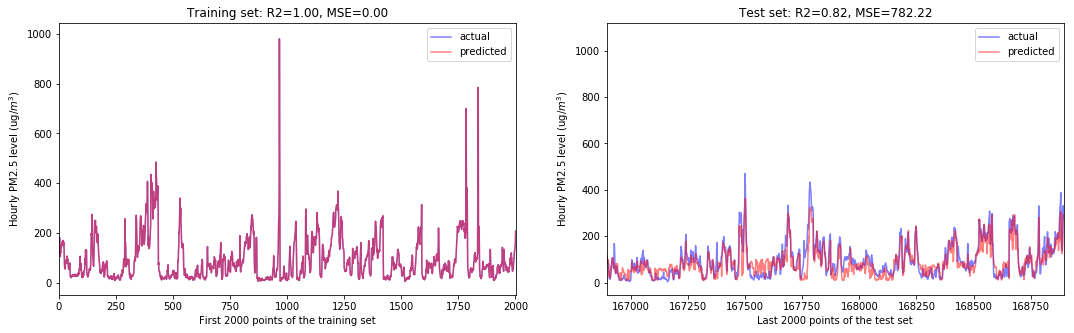

In [55]:
# update model with the best parameters
knr_2 = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_neighbors=71, weights='distance'))])
knr_2.fit(X_2_train, y_2_train)
pred_train = knr_2.predict(X_2_train)
pred_test = knr_2.predict(X_2_test)

compute_plot_result_2("KNeighborsRegressor", pred_train, pred_test)

### 4.6 MLPRegressor model with the new lag feature

In [ ]:
# initialize a MLPRegressor model using default parameters
mlpr_2 = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor())])

# grid search of parameters hidden_layer_sizes, activation to improve MLPRegressor model
parameters = {'mlpr__activation': ['identity','logistic','tanh','relu'],'mlpr__hidden_layer_sizes':[(100,),(100,20),(50,100),(50,100,20)]}
mlpr_2_cv = GridSearchCV(mlpr_2, parameters, scoring='r2',cv=3)
mlpr_2_cv.fit(X_2_train.iloc[idx_rand_2], y_2_train.iloc[idx_rand_2]) # randomize the ordering of the training set
print('Best parameters:', mlpr_2_cv.best_params_)
print('Corresponding R2 score:', mlpr_2_cv.best_score_)

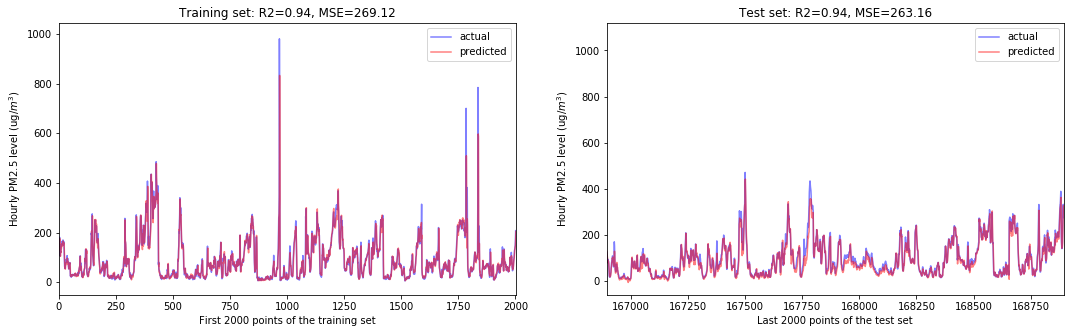

In [56]:
# update model with the best parameters
mlpr_2 = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor(hidden_layer_sizes=(100,), activation='relu'))])
mlpr_2.fit(X_2_train, y_2_train)
pred_train = mlpr_2.predict(X_2_train)
pred_test = mlpr_2.predict(X_2_test)

compute_plot_result_2("MLPRegressor", pred_train, pred_test)

### 4.7 Model comparison

In [57]:
print(score_table_2)

                           r2_train   r2_test mse_train mse_test
LinearRegression           0.939551  0.941042   295.604  252.903
Lasso                       0.93955  0.941047   295.607  252.881
Ridge                      0.939551  0.941042   295.604  252.905
RandomForestRegressor      0.992281  0.891974   37.7463  463.384
GradientBoostingRegressor  0.938485  0.901223   300.813  423.713
KNeighborsRegressor               1  0.817646         0  782.219
MLPRegressor               0.944967  0.938652   269.119  263.158


### 4.8 Section summary 

* The machine learning models from section 3 are updated with the new lag feature. In addition, both data of year 2015 and data of city 'shenyang' are reserved as the holdout test set, whereas only data from the other four cities in year 2010-2014 are used as the training set, to evaluate the model's capability for forecasting not only into the future but also for an unseen city.
* The results reveal that, in this particular problem, it’s very useful to include the lag feature from previous steps for predicting future steps and R2 scores are boosted significantly regardless of the model used. In fact, simple linear models report a pretty good R2 score of 0.94 on the test set, whereas more advanced models do not show further improvement. 
* The results from these machine learning models reveal that among all features, the newly added lag feature accounts for about 80% of the contribution, meteological (weather) and geographic (city) features account for about 15% and the rest 5% is attributed to the datetime based features.
* In addition, the models powered by the additional lag feature not only forecast into the future, but also extends to predict an unseen city.

## 5. Conclusion
In order to predict the air quality (PM2.5 value) for five major Chinese cities, three different methodologies are implemented in this study: 

1. Time series PM2.5 data alone is first modeled using ARIMA model for each city: <br>
The results show that ARIMA models with various combinations of p, d, q parameters share very similar performances, with acceptable mean-squared-error on the training set, good precision for the very first out-of-sample prediction into the future, but poor predictions for further steps into the future.<br>
In addition, SARIMA model is also carried out for the time series PM2.5 data with a daily frequency to further account for the observed seasonal component (yearly). Again, the SARIMA model only provides a reasonable prediction for the very first data point into the future, but fails to predict further steps.<br>
This suggests that the autoaggressive and moving average patterns in the time series alone are not enough to predict multiple steps into the future. There are other underlying factors causing non-repetitive changes in PM2.5 values.


2. Machine learn models are constructed by incorporating available meteorological weather data (temperature, pressure, dew point, wind direction, wind speed, precipitation): <br>
Here, the datetime information is represented as year, month, day, hour and season, and used as features along with the meteorological data. Data of all five cities in year 2010-2014 are used as training set, and data of five cities in year 2015 is used as the holdout test set.<br>
Various machine learning models are constructed following this methodology. Simplier linear models (LinearRegression, Lasso and Ridge) only achieves R2=0.21 on the test set. Among more advanced models, KNeighborsRegressor gives R2 of 0.35; ensemble methods, like RandomForestRegressor and GradientBoostingRegressor, achieve R2 of 0.35-0.4; In addition, nueral-net based MLPRegressor is also tried out with a reported R2 of 0.35. <br>
The results from these machine learning models reveal that among all meteorological parameters, wind speed (ws), temperature (temp), humidity (humi) and dew point (dewp) are the top influencers; among all datetime-related parameters, month is the most important factor, followed by hour and day. <br>
In addition, separate machine learning models are built for individual cities. By separating out the 'city' feature into individual models, R2 is improved from 0.35-0.4 to 0.45-0.5. But, further improvements are hard without additional feature engineering. <br> 
These suggest that although time-related information and weather conditions can only explain the variations in air quality (PM2.5 value) to a limited extent. There are other underlying reasons causing the PM2.5 trends and variations. <br>


3. Given the conclusions from method 1 & 2, and the fact that PM2.5 is intrinsicly a time series that progresses on its previous values, an additional lag feature of 1 hour (value from the previous one step) is introduced to take into consideration the impact from its previous values (autoregressive nature). <br> 
The machine learning models from 2 are updated with the new lag feature. In addition, both data of year 2015 and data of city 'shenyang' are reserved as the holdout test set, whereas only data from the other four cities in year 2010-2014 are used as the training set, to evaluate the model's capability for forecasting not only into the future but also for an unseen city. <br>
The results reveal that, in this particular problem, it’s very useful to include the lag feature from previous steps for predicting future steps and R2 scores are boosted significantly regardless of the model used. In fact, simple linear models report a pretty good R2 score of 0.94 on the test set, whereas more advanced models do not show further improvement. The results from these machine learning models reveal that among all features, the newly added lag feature accounts for about 80% of the contribution, meteological (weather) and geographic (city) features account for about 15% and the rest 5% is attributed to the datetime based features. <br>
In addition, the models powered by the additional lag feature not only forecast into the future, but also extends to predict an unseen city. <br>

To conclude, predicting air quality (PM2.5) is a complicated problem, as there are many underlying factors all playing an role in shaping PM2.5. As revealed in this study, both previous observed value and various weather conditions have an impact on future PM2.5 values. Given that for the winning models, the previous observation is crucial in predicting the next step, the model's capacity for predicting the future is limited. For practical use, pipeline should be developed to log the forecasted PM2.5 values to enable further predictions, and update the dataset whenever a new observation is available to improve the accuracy. <br>

### Potential future work
consider downsampling the entire dataset on a daily frequency and use lag feature of 1 day